Hi, my name is Ankur Jain and I'm a sophomore studying Computer Science + Business at the University of California, Berkeley. As a Los Angeles native, I had quite of bit of fun analyzing the data and learning more about bikeshareing in LA. Please feel free to email me at [ankur.jain@berkeley.edu](ankur.jain@berkeley.edu) with any comments or questions, and you can find my LinkedIn at this [link](http://linkedin.com/in/Ankur-J).

The first thing we'll do is import our data, and parse the timestamps to make them easier to work with. Just to make sure everything was imported correctly, the first few rows of our dataset are printed below.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geopy.distance import great_circle
import datetime

def parse_my_date(x):
    return datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S")
types = {'Trip ID':float, 'Duration':float, 'Start Time':str, 'End Time':str, 'Starting Station ID':float, 'Starting Station Latitude':float, 'Starting Station Longitude':float, 'Ending Station ID':float, 'Ending Station Latitude':float, 'Ending Station Longitude':float, 'Bike ID':float, 'Plan Duration':float, 'Trip Route Category':str, 'Passholder Type':str, 'Starting Lat-Long':dict, 'Ending Lat-Long':dict}

df = pd.read_csv('metro-bike-share-trip-data.csv', dtype=types, parse_dates=[2, 3], date_parser=parse_my_date).fillna(0)
df.head()

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long
0,1912818,180,2016-07-07 04:17:00,2016-07-07 04:20:00,3014,34.056610,-118.23721,3014,34.056610,-118.23721,6281,30,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."
1,1919661,1980,2016-07-07 06:00:00,2016-07-07 06:33:00,3014,34.056610,-118.23721,3014,34.056610,-118.23721,6281,30,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."
2,1933383,300,2016-07-07 10:32:00,2016-07-07 10:37:00,3016,34.052898,-118.24156,3016,34.052898,-118.24156,5861,365,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05..."
3,1944197,10860,2016-07-07 10:37:00,2016-07-07 13:38:00,3016,34.052898,-118.24156,3016,34.052898,-118.24156,5861,365,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05..."
4,1940317,420,2016-07-07 12:51:00,2016-07-07 12:58:00,3032,34.049889,-118.25588,3032,34.049889,-118.25588,6674,0,Round Trip,Walk-up,"{'longitude': '-118.25588', 'latitude': '34.04...","{'longitude': '-118.25588', 'latitude': '34.04..."


The first thing I did with the dataset was produce some straightforward graphs to get a general understanding of the information. In the histogram below, it's no surprise that most bikeshare trips were relatively short, but it's interesting that we see a number of trips at the far right of the graph.

In the second graph, Duration is plotted against Trip ID, which roughly measures the duration of bikeshare trips over time, since the Trip ID's are monotonically increasing. Although it seems to be roughly scattered across the chart, we can see a slight upwards trend as time increases. This might be due to the fact that there are more simply more riders, but it also may point to an increasing demand for longer bike rides.

Third, I found it interesting that riders with 365 Day plans tended to take the shortest trips, while Walk-Ups tended to have the longest rides. Monthly plan users were somewhere in the middle, while still having many short-length trips.

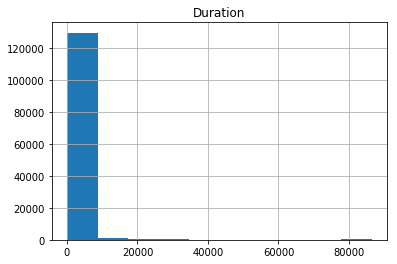

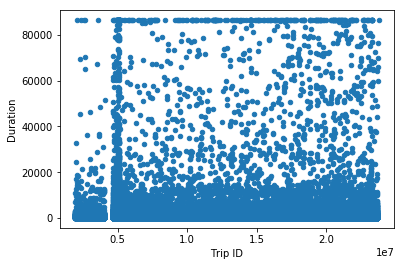

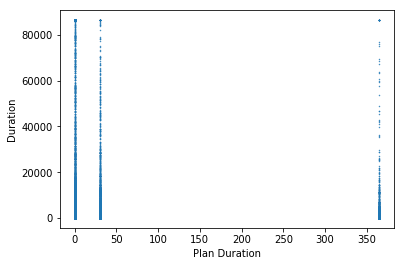

In [49]:
df.hist('Duration')
plt.show()

df.plot.scatter('Trip ID', 'Duration')
plt.show()

df.plot.scatter('Plan Duration', 'Duration', 0.2)
plt.show()

To calculate the average distance traveled in one bike ride, I had to figure out some way to extract the information from the data given. I decided to first group the data by round-trips and one-way trips, which would allow me to get an accurate representation of the distance traveled. For round-trips, I calculated the distance traveled by multiplying the duration by the average miles per second, which I calculated using the data from the one-way trips. Putting it all together, I approximated the average distance traveled per trip to be somehwere around 0.8656 miles.

In [50]:
def calculate_avg_miles_per_sec():
    total_dist = 0
    total_time = 0
    na = (0, 0)
    na_count = 0
    for index, row in df.iterrows():
        start = (row['Starting Station Latitude'], row['Starting Station Longitude'])
        end = (row['Ending Station Latitude'], row['Ending Station Longitude'])
        if start == na or end == na:
            na_count += 1
        elif start != end:
            total_dist += great_circle(start, end).miles
            total_time += row['Duration']
    return total_dist / total_time

def calculate_average_dist_per_ride(avg_miles_per_sec):
    total_dist = 0
    na = (0, 0)
    na_count = 0
    valid_rides = 0
    for index, row in df.iterrows():
        start = (row['Starting Station Latitude'], row['Starting Station Longitude'])
        end = (row['Ending Station Latitude'], row['Ending Station Longitude'])
        if start == na or end == na:
            na_count += 1
        elif start == end:
            total_dist += avg_miles_per_sec * row['Duration']
            valid_rides += 1
        else:
            total_dist += great_circle(start, end).miles
            valid_rides += 1
    return total_dist / valid_rides

print("Average Distance Traveled Per Trip: ", calculate_average_dist_per_ride(calculate_avg_miles_per_sec()))


Average Distance Traveled Per Trip:  0.8656059331974946


To find the most popular start and end stations, we can use *panda*'s built-in *mode()* function, which will find the Start and End Stations with the most occurrences in our dataset. Below those calculations, I created a HashMap of the Station ID's and their latitudes and longitudes, which proved useful in the next section.

In [51]:
print("Most popular Start Station: ", df.mode()['Starting Station ID'][0])
print("Most popular End Station: ", df.mode()['Ending Station ID'][0])

start_stations = {}
end_stations = {}
start_locations = {}
end_locations = {}
for index, row in df.iterrows():
    start = row['Starting Station ID']
    end = row['Ending Station ID']
    if start in start_stations:
        start_stations[start] += 1
    else:
        start_stations[start] = 1
        start_locations[start] = (row['Starting Station Latitude'], row['Starting Station Longitude'])
    if end in end_stations:
        end_stations[end] += 1
    else:
        end_stations[end] = 1
        end_locations[end] = (row['Ending Station Latitude'], row['Ending Station Longitude'])

max_start = start_stations[max(start_stations.keys(), key=lambda x:start_stations[x])]
min_start = start_stations[min(start_stations.keys(), key=lambda x:start_stations[x])]




Most popular Start Station:  3069.0
Most popular End Station:  3005.0


If we graph the Station ID's and their counts, we can see get a visual description of the distribution. Noticeably, the stations near Downtown are some of the most popular.

Feel free to interact and click on the markers in the graph below.

In [30]:
from folium import Map, CircleMarker

starting_points = Map(location=[34.0486, -118.2529], zoom_start=14, tiles="CartoDB positron")
d = [[start_locations[station][0], start_locations[station][1], str(int(((start_stations[station] - min_start) / (max_start - min_start))*2.9)), station] for station in start_stations]

for station in d:
    my_color = ""
    if station[2] == "0":
        my_color = "#5de02a"
    if station[2] == "1":
        my_color = "#f1c94a"
    if station[2] == "2":
        my_color = "#c51414"
    CircleMarker(location=[station[0], station[1]], color=my_color, popup='ID: %d \n Counts: %d'%(station[3], start_stations[station[3]]), fill=True).add_to(starting_points)

starting_points

In order to break down the combinations of Trip Route and Passholder Type, I created a few HashMaps and aggregated the data using Google Charts. Interestingly, most round-trips are done by walk-ups, which suggests that it might beneficial to target that market segment and expand it. 

Feel free to interact with the graph below.

In [9]:
from iplotter import GCPlotter

passholder_routes = {}
passholder_counts = {}
for index, row in df.iterrows():
    ph = row['Passholder Type']
    r = row['Trip Route Category']
    if ph in passholder_counts:
        passholder_counts[ph] += 1
    else:
        passholder_counts[ph] = 1
    if r == 'One Way':
        if ph in passholder_routes:
            passholder_routes[ph] += 1
        else:
            passholder_routes[ph] = 1
            
chart_data = [
    ['Type of Trip', 'One-Way', 'Round Trips', {"role": 'annotation'}],
    ['Monthly Pass', passholder_routes['Monthly Pass'], passholder_counts['Monthly Pass'] - passholder_routes['Monthly Pass'], ''],
    ['Flex Pass', passholder_routes['Flex Pass'], passholder_counts['Flex Pass'] - passholder_routes['Flex Pass'], ''],
    ['Walk-up', passholder_routes['Walk-up'], passholder_counts['Walk-up'] - passholder_routes['Walk-up'], ''],
    ['Staff Annual', passholder_routes['Staff Annual'], passholder_counts['Staff Annual'] - passholder_routes['Staff Annual'], '']
]

chart_options = {
    "width": 1000,
    "height": 600,
    "legend": {"position": 'top', "maxLines": 3},
    "bar": {"groupWidth": '80%'},
    "isStacked": "true",
}

plotter = GCPlotter()
plotter.plot(chart_data, chart_type="ColumnChart",chart_package='corechart', options=chart_options)

To calculate how many riders included bikesharing in their commute, I first analyzed weekdays where the starting and ending locations of the riders swapped at least once. Then I deducted those values from the running totals and took the average across all dates to find an approximation for the number of people using bikesharing to get to and from work everyday.

In [52]:
dates_to_rows = {}
for index, row in df.iterrows():
    curr_time = row['Start Time'].date()
    weekday = row['Start Time'].weekday()
    if weekday == 5 or weekday == 6:
        continue
    if curr_time in dates_to_rows:
        dates_to_rows[curr_time].append([row['Starting Station ID'], row['Ending Station ID']])
    else:
        dates_to_rows[curr_time] = [[row['Starting Station ID'], row['Ending Station ID']]]
totals = []
for date_ in dates_to_rows:
    original_size = len(dates_to_rows[date_])
    for row in dates_to_rows[date_]:
        try:
            dates_to_rows[date_].remove(row)
        except ValueError as e:
            None
        row[0], row[1] = row[1], row[0]
        try:
            dates_to_rows[date_].remove(row)
        except ValueError as e:
            None
            # We simply catch the exception
    final_size = len(dates_to_rows[date_])
    totals.append((original_size - final_size) // 2)
print("How many riders include bike sharing as a regular part of their commute: ", sum(totals) / len(totals))
        

How many riders include bike sharing as a regular part of their commute:  149.76041666666666
